In [1]:
#auto reimport packages
%load_ext autoreload
%autoreload 2

In [2]:
DATA_NAME = 'LK99'
DATA_PATH = f'../data/{DATA_NAME}/IVcurve'

import os, pandas as pd, numpy as np, re
import matplotlib.pyplot as plt
# Set consistent plotting style
plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial'],
    'axes.labelcolor': '#4A4A4A',
    'axes.titlecolor': '#4A4A4A'
}) 
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import LinearRegression

all_data = pd.DataFrame()

def extract_temp(filename):
    match = re.search(r'(\d+)K', filename)
    return int(match.group(1)) if match else 0

for file in sorted(os.listdir(DATA_PATH), key=extract_temp):
    if not file.endswith('.csv'):
        continue
    
    df = pd.read_csv(os.path.join(DATA_PATH, file), skiprows=4, low_memory=False)
    df['temperature_K'] = extract_temp(file)
    df['current_mA'] = df['Reading'] * 1000
    
    all_data = pd.concat([all_data, df], ignore_index=True)
    print(f"Preview of {file}:")
    print(df.head(), "\n")


Preview of 300K.csv:
   Reading Number  Reading  Source Value  temperature_K  current_mA
0               1 -1.50057          -3.0            300    -1500.57
1               2 -1.50057          -2.9            300    -1500.57
2               3 -1.50056          -2.8            300    -1500.56
3               4 -1.50055          -2.7            300    -1500.55
4               5 -1.50053          -2.6            300    -1500.53 

Preview of 325K.csv:
   Reading Number  Reading  Source Value  temperature_K  current_mA
0               1 -1.50057          -3.0            325    -1500.57
1               2 -1.50056          -2.9            325    -1500.56
2               3 -1.50056          -2.8            325    -1500.56
3               4 -1.50057          -2.7            325    -1500.57
4               5 -1.50054          -2.6            325    -1500.54 

Preview of 350K.csv:
   Reading Number  Reading  Source Value  temperature_K  current_mA
0               1 -1.50057          -3.0         

In [59]:
# Calculate resistance from IV curve
resistance_by_temp = {}

for temp in all_data['temperature_K'].unique():
    temp_data = all_data[all_data['temperature_K'] == temp]
    
    # Filter out near-zero current points and limit voltage range between -2V and 2V
    threshold = 1e-6
    boundary = 1.8
    mask = (np.abs(temp_data['current_mA']) > threshold) & (temp_data['Source Value'] >= -boundary) & (temp_data['Source Value'] <= boundary)
    
    if sum(mask) > 2:
        # Use a robust linear regression method to calculate the slope
        model = RANSACRegressor(estimator=LinearRegression())
        X = temp_data['current_mA'][mask].values.reshape(-1, 1)
        y = temp_data['Source Value'][mask].values
        
        model.fit(X, y)
        slope = model.estimator_.coef_[0]
        resistance_by_temp[temp] = slope*1000 if slope != 0 else np.nan
    else:
        resistance_by_temp[temp] = np.nan
    
    all_data.loc[all_data['temperature_K'] == temp, 'resistance'] = resistance_by_temp[temp]

In [63]:
# all_data.to_csv("temp.csv", index=False)

In [51]:
all_data = pd.read_csv("temp.csv")

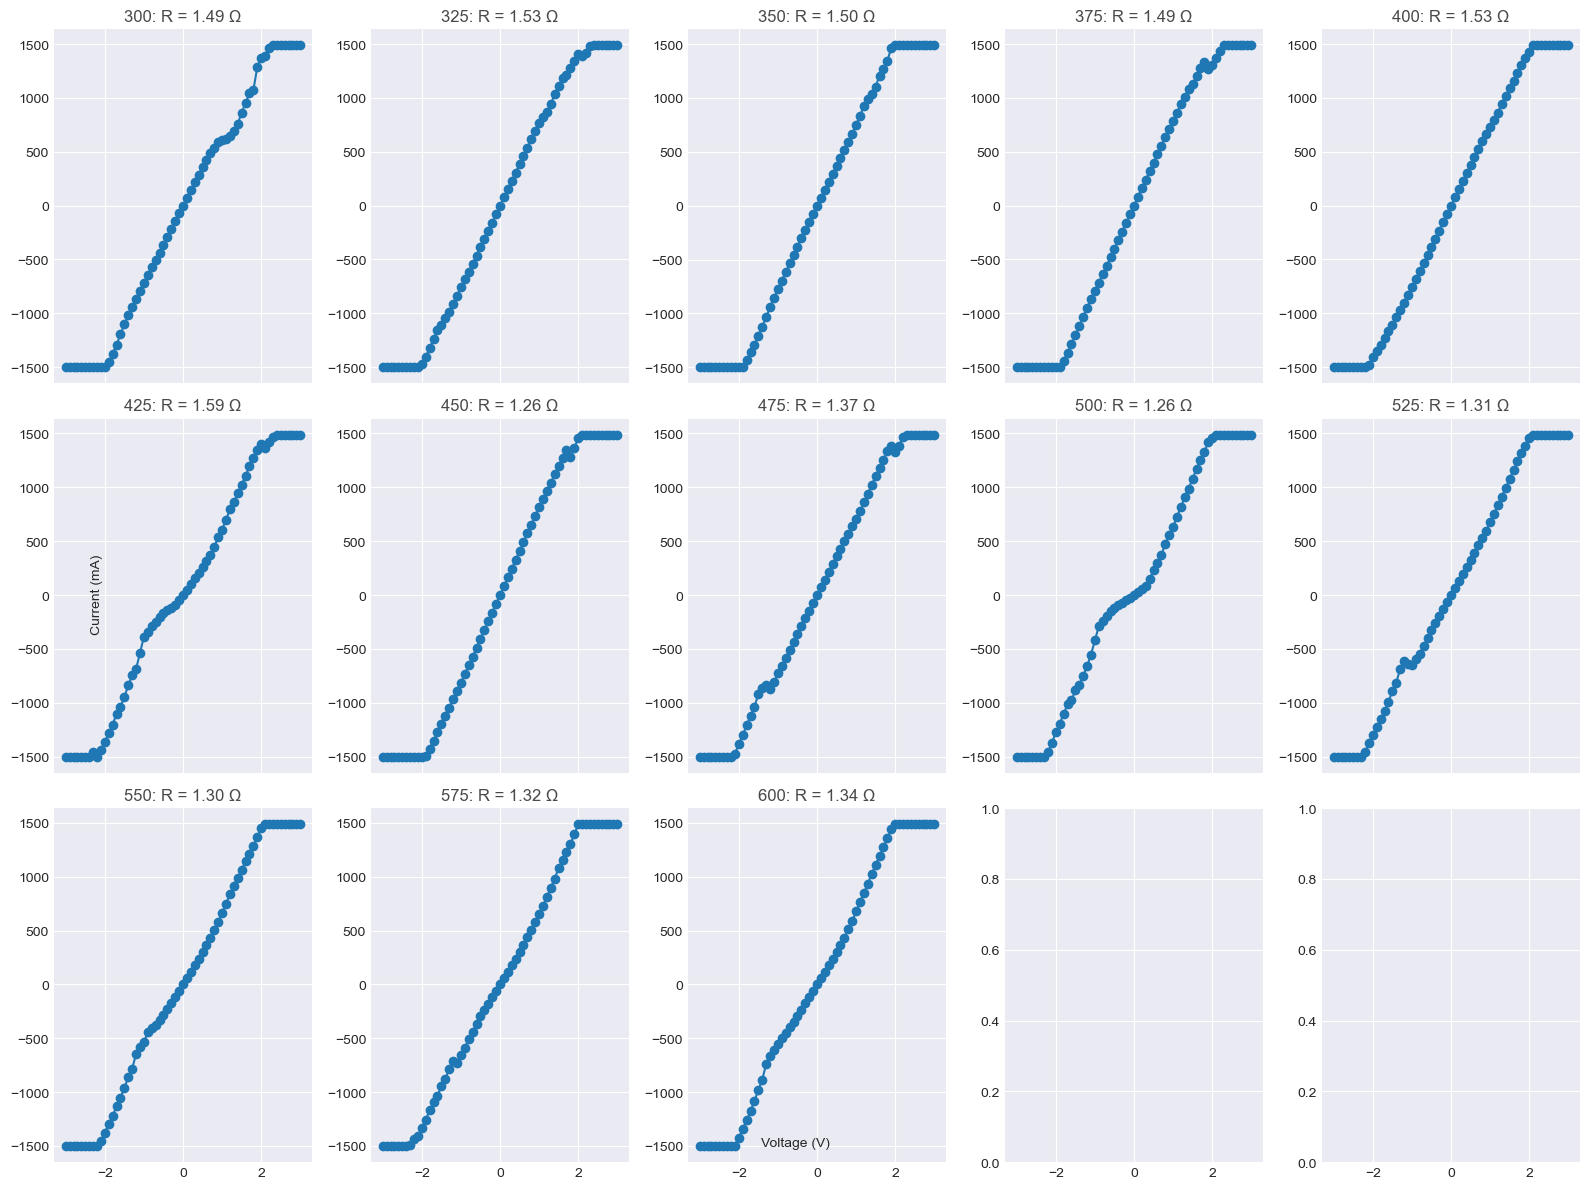

In [52]:
# Plot IV curves
num_temps = len(all_data['temperature_K'].unique())
num_cols = 5
num_rows = (num_temps + num_cols - 1) // num_cols  # Calculate the number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(16, 4 * num_rows), sharex=True, sharey=False)
axes = axes.flatten()

for i, temp in enumerate(all_data['temperature_K'].unique()):
    if i >= len(axes): break
    temp_data = all_data[all_data['temperature_K'] == temp]
    resistance = temp_data['resistance'].iloc[0]  # Get the resistance from all_data
    axes[i].plot(temp_data['Source Value'], temp_data['current_mA'], 'o-')
    axes[i].set_title(f'{temp}: R = {resistance:.2f} Ω')
    axes[i].grid(True)

fig.text(0.5, 0.04, 'Voltage (V)', ha='center')
fig.text(0.06, 0.5, 'Current (mA)', va='center', rotation='vertical')
plt.tight_layout()
plt.show()



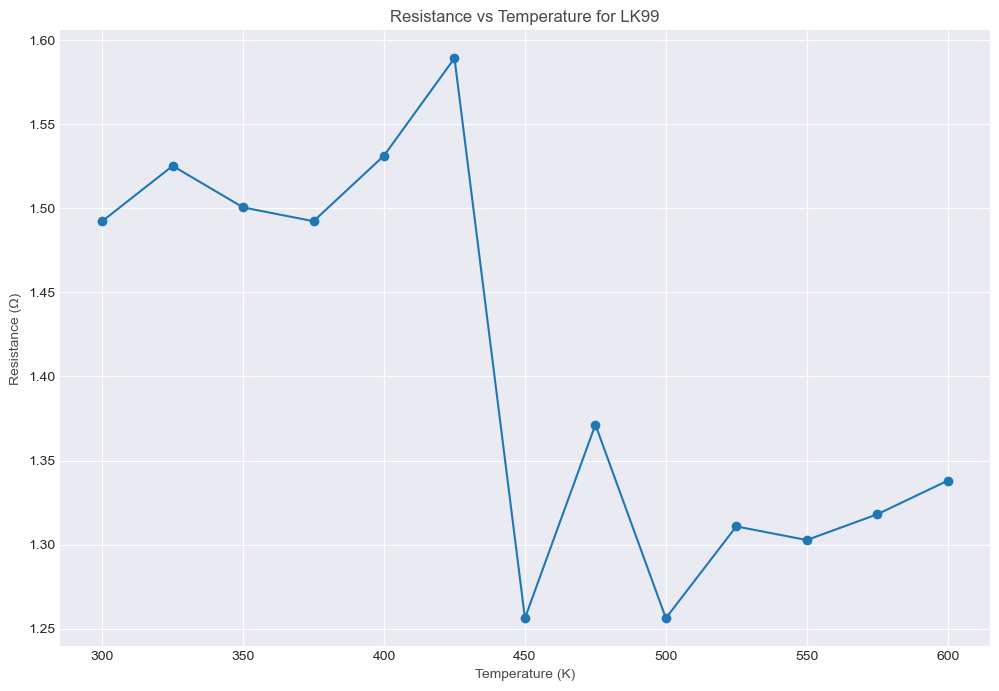

In [53]:
# Plot resistance vs temperature
plt.figure(figsize=(12, 8))
temps = all_data['temperature_K'].unique()
res_values = [all_data[all_data['temperature_K']==t]['resistance'].mean() for t in temps]
plt.plot(temps, res_values, 'o-')
plt.xlabel('Temperature (K)')
plt.ylabel('Resistance (Ω)')
plt.title("Resistance vs Temperature for LK99")
plt.grid(True)
plt.show()